#Load data

In [13]:
#https://drive.google.com/file/d/1cxYSDoJqJAz56hdBUa6_bTlmmwyJkqMA/view?usp=sharing
# Load data
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
data = pd.read_csv("weatherAUS.csv")

In [14]:
#Clean data
data = data.dropna()
data = data.dropna(subset=['MinTemp','MaxTemp','Rainfall','Humidity3pm','Pressure3pm','Temp3pm','RainToday','WindGustSpeed','RainTomorrow'])
data.to_csv("weatherAUS_Clean.csv", index=False)
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


In [15]:
#เเปลงข้อมูล
le_rain = LabelEncoder()
le_raintoday = LabelEncoder()

data['RainToday'] = le_raintoday.fit_transform(data['RainToday'])
data['RainTomorrow'] = le_rain.fit_transform(data['RainTomorrow'])

In [16]:
# Define features (X) and target (y)
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Humidity3pm', 'Pressure3pm', 'Temp3pm', 'RainToday', 'WindGustSpeed']
X = data[features]
y = data['RainTomorrow']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [18]:
print("ข้อมูลทั้งหมด:", len(data))
print("ข้อมูลที่ใช้เทรน:", len(X_train))
print("ข้อมูลที่ใช้เทสต์:", len(X_test))

ข้อมูลทั้งหมด: 56420
ข้อมูลที่ใช้เทรน: 39494
ข้อมูลที่ใช้เทสต์: 16926


#Grid Search

In [31]:
from sklearn.model_selection import cross_val_score, ShuffleSplit, ParameterGrid
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# ===== Parameter Grid (Medium Level) =====
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=42)

best_acc = 0
best_params = None

print("\n............รอเเปปเดียว...........\n")
for params in ParameterGrid(param_grid):
    rf = RandomForestClassifier(**params, random_state=42)
    scores = cross_val_score(rf, X_train_res, y_train_res, cv=cv, n_jobs=-1)
    mean_acc = scores.mean()

    print(mean_acc)

    if mean_acc > best_acc:
        best_acc = mean_acc
        best_params = params

print(f"\nBest Parameters: {best_params}, Max accuracy: {best_acc:.4f}")


............รอเเปปเดียว...........

0.8153656319002468
0.8164913192189461
0.8150192665714163
0.8148677317400527
0.814348183746807
0.8149976187383642
0.8140018184179764
0.8144564229120665
0.9354028661730961
0.9353379226739404
0.9257695804649955
0.9263757197904491
0.9166341949170889
0.9187340347231242
0.9149673117720916
0.9153569727670261

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, Max accuracy: 0.9354


#Model RandomForest

In [34]:
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_res, y_train_res)

y_pred = best_rf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy บน Test set: {test_acc:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy บน Test set: 0.8405

Confusion Matrix:
 [[12096  1102]
 [ 1597  2131]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     13198
           1       0.66      0.57      0.61      3728

    accuracy                           0.84     16926
   macro avg       0.77      0.74      0.76     16926
weighted avg       0.83      0.84      0.84     16926



Text(70.72222222222221, 0.5, 'True')

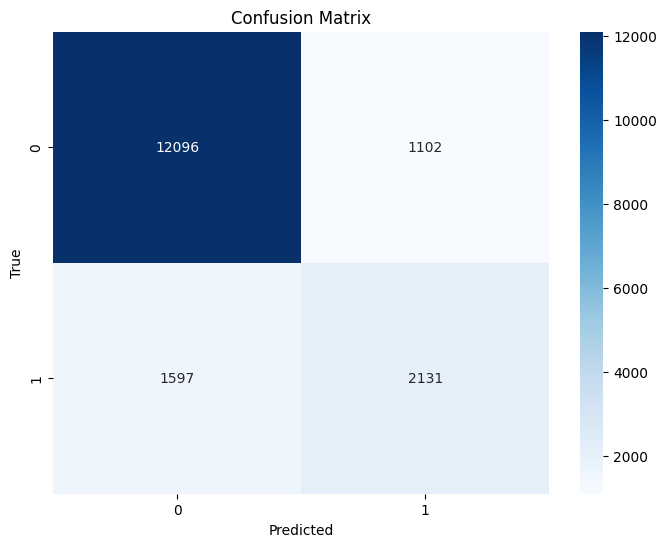

In [35]:
# เเสดง seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

plt.xlabel('Predicted')
plt.ylabel('True')

/tmp/ipython-input-2734305645.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette='viridis')


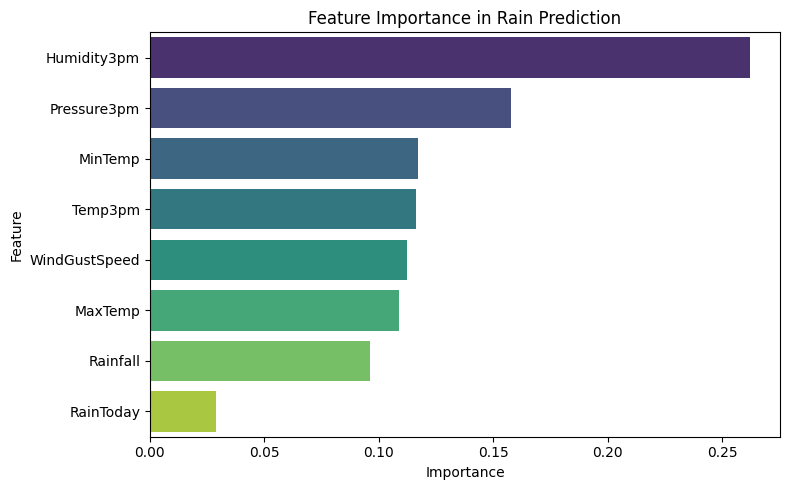

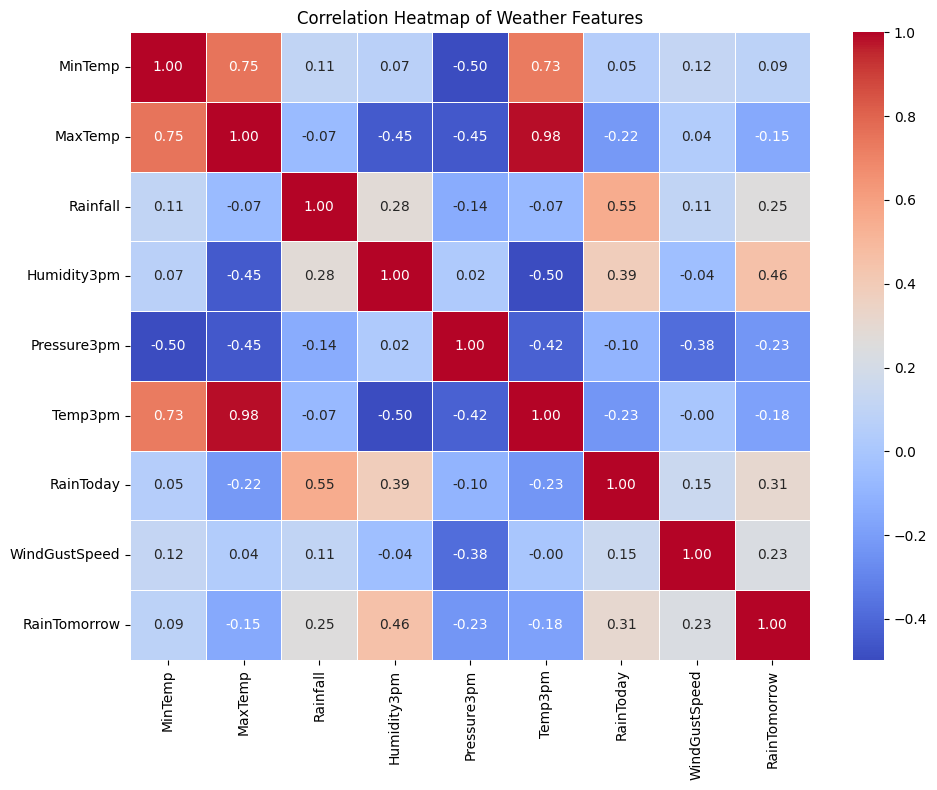

In [36]:
# ===== วิเคราะห์ Feature Importance และ Correlation =====
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Feature Importance
importances = best_rf.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance, y=feature_importance.index, palette='viridis')
plt.title("Feature Importance in Rain Prediction")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data[features + ['RainTomorrow']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Weather Features")
plt.tight_layout()
plt.show()


In [37]:
# บันทึกโมเดล RandomForest
joblib.dump(best_rf, "rf_rain_model.pkl", compress=3, protocol=4)
# บันทึก LabelEncoder
joblib.dump(le_rain, "le_rain.pkl", compress=3, protocol=4)
joblib.dump(le_raintoday, "le_raintoday.pkl", compress=3, protocol=4)

['le_raintoday.pkl']

#App

In [38]:
!pip install streamlit pyngrok

In [39]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# โหลดโมเดล
rf = joblib.load("rf_rain_model.pkl")
le_rain = joblib.load("le_rain.pkl")
le_raintoday = joblib.load("le_raintoday.pkl")

st.title("Rain Prediction App")
st.write("กรอกข้อมูลสภาพอากาศเพื่อพยากรณ์ว่าพรุ่งนี้จะมีฝนหรือไม่")

# กรอกข้อมูล
mintemp = st.number_input("MinTemp (°C)", -10.0, 40.0, 10.0)
maxtemp = st.number_input("MaxTemp (°C)", -10.0, 50.0, 25.0)
rainfall = st.number_input("Rainfall (mm)", 0.0, 500.0, 0.0)
humidity3pm = st.number_input("Humidity 3 PM (%)", 0, 100, 57)
pressure3pm = st.number_input("Pressure 3 PM (hPa)", 900.0, 1100.0, 1017.6)
temp3pm = st.number_input("Temperature 3 PM (°C)", -10.0, 50.0, 21.8)
windgustspeed = st.number_input("Wind Gust Speed (km/h)", 0.0, 200.0, 35.0)
raintoday = st.selectbox("Did it rain today?", ["No", "Yes"])

# แปลงข้อมูล raintoday
raintoday_encoded = le_raintoday.transform([raintoday])[0]

# รวมข้อมูลเข้า DataFrame
user_input = pd.DataFrame([{
    'MinTemp': mintemp,
    'MaxTemp': maxtemp,
    'Rainfall': rainfall,
    'Humidity3pm': humidity3pm,
    'Pressure3pm': pressure3pm,
    'Temp3pm': temp3pm,
    'RainToday': raintoday_encoded,
    'WindGustSpeed': windgustspeed
}])

if st.button("Predict Rain Tomorrow"):
    #class
    prediction = rf.predict(user_input)[0]
    prediction_label = le_rain.inverse_transform([prediction])[0]

    #%
    prob_rain = rf.predict_proba(user_input)[0][1] * 100

    st.markdown(f"### ผลการพยากรณ์: **{'🌧️ ฝนตก' if prediction_label == 'Yes' else '☀️ ไม่ตก'}**")
    st.write(f"🔹 ความน่าจะเป็นที่ฝนจะตกพรุ่งนี้: **{prob_rain:.2f}%**")

Overwriting app.py
